In [1]:
# Run this cell to mount your drive to this notebook in order to read the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [3]:
# Put the folder path where the datasets are located
PATH = "/content/drive/MyDrive/CS445/Project 1/"

In [4]:
# Read the train and test set with read_csv() method of pandas
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")

In [ ]:
train.head(3)

,Unnamed: 0,text,label
0,0,I came here and left a review before but last ...,1
1,1,Had a very nice first visit here. The owner Te...,4
2,2,This is a gorgeous and very clean hotel. We h...,4


In [ ]:
#check if there exists nan values
train.isnull().sum()

Unnamed: 0    0
text          0
label         0
dtype: int64

In [5]:
train = train.drop('Unnamed: 0' , axis = 1)
test = test.drop('Unnamed: 0', axis = 1)

### Preprocess Dataset

In [6]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re

import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
# Define a function to perform preprocessing. This function can perform things like lowercasing, stemming, removing stopwords, etc.
 
stop_words = set(stopwords.words('english'))
def preprocess(text: str):
  #lowercasing
  text = text.lower()
  #remove html tags
  text = BeautifulSoup(text).get_text()
  #remove URLs
  text = re.sub(r'http\S+' , '', text)
  #punctuation removal
  text = text.translate(text.maketrans('', '', string.punctuation))
  #remove extra white spaces
  text = re.sub(' +', ' ', text)
  #tokenization
  word_tokens = word_tokenize(text)
  #stop word removal
  text = ' '.join([w for w in word_tokens if w not in stop_words])
  
  return text

In [8]:
# Apply your preprocessing function to your text fields.

train.text = train.text.apply(preprocess)
test.text = test.text.apply(preprocess)

train.shape, test.shape

((18000, 2), (2000, 2))

In [ ]:
# Create your binary and multiclass datasets
binary_train = train.sample(frac=0.5, random_state = 200)
multiclass_train = train.drop(binary_train.index)

binary_test = test.sample(frac=0.5, random_state=200)
multiclass_test = test.drop(binary_test.index)



# For binary dataset, get rid of the class 3 in the dataset and map class 1 and 2 to 0, and class 4 and 5 to 1
#drop the rows which has label == 3
binary_train = binary_train.drop(binary_train[binary_train.label == 3].index)
binary_train.loc[binary_train["label"] == 1, "label"] = 0
binary_train.loc[binary_train["label"] == 2, "label"] = 0
binary_train.loc[binary_train["label"] == 4, "label"] = 1
binary_train.loc[binary_train["label"] == 5, "label"] = 1


#do the train and test handling for binary_test
#drop the rows which has label == 3
binary_test = binary_test.drop(binary_test[binary_test.label == 3].index)

binary_test.loc[binary_test["label"] == 1, "label"] = 0
binary_test.loc[binary_test["label"] == 2, "label"] = 0
binary_test.loc[binary_test["label"] == 4, "label"] = 1
binary_test.loc[binary_test["label"] == 5, "label"] = 1

binary_train_x = binary_train['text']
binary_train_y = binary_train['label']

binary_test_x = binary_test['text']
binary_test_y = binary_test['label']

# For multiclass dataset, make sure your classes starts from 0 and goes until 4. (5->4, 4->3, 3->2, 2->1, 1->0)
for i in range(1,6):
  multiclass_train.loc[multiclass_train["label"] == i, "label"] = i-1
  multiclass_test.loc[multiclass_test["label"] == i, "label"] = i-1

multiclass_train_x = multiclass_train["text"]
multiclass_train_y = multiclass_train["label"]

multiclass_test_x = multiclass_test["text"]
multiclass_test_y = multiclass_test["label"]

# Models

## Non-Neural Models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score

### Naive Bayes

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

# Create a class for converting sparse matrix output of TfidfVectorizer to dense matrix for feeding into GaussianNB
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# Initiate the pipeline with required components.You can use Pipeline class of sklearn -> https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# There will be three components; 1) TfidfVectorizer 2) DenseTransformer 3) Naive Bayes classifier.

naiveBayes_components = [('TfidfVectorizer' , TfidfVectorizer(analyzer = 'word')), ('DenseTransformer' , DenseTransformer()), ('NBClassifier' , GaussianNB())]
naiveBayes_pipeline = Pipeline(naiveBayes_components)

#tfidfvectorizer = TfidfVectorizer()
#tfidf_wm = tfidfvectorizer.fit_transform(binary_train['text'])
#tfidf_wm = tfidfvectorizer.fit_transform(' '.join(map(str,binary_train['text'])))



# Set the hyperparameter space that will be scanned with GridSearchCV.
grid_parameters =  {
    'TfidfVectorizer__ngram_range' : [(1,1) , (1,2), (1,3) ],
    'TfidfVectorizer__min_df' : [100, 500, 1000]

}



#### Binary

In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.

clf = GridSearchCV(naiveBayes_pipeline, grid_parameters,verbose=10, scoring='f1_macro')
clf.fit(binary_train_x, binary_train_y)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START TfidfVectorizer__min_df=100, TfidfVectorizer__ngram_range=(1, 1)
[CV 1/5; 1/9] END TfidfVectorizer__min_df=100, TfidfVectorizer__ngram_range=(1, 1);, score=0.858 total time=   0.4s
[CV 2/5; 1/9] START TfidfVectorizer__min_df=100, TfidfVectorizer__ngram_range=(1, 1)
[CV 2/5; 1/9] END TfidfVectorizer__min_df=100, TfidfVectorizer__ngram_range=(1, 1);, score=0.848 total time=   0.4s
[CV 3/5; 1/9] START TfidfVectorizer__min_df=100, TfidfVectorizer__ngram_range=(1, 1)
[CV 3/5; 1/9] END TfidfVectorizer__min_df=100, TfidfVectorizer__ngram_range=(1, 1);, score=0.836 total time=   0.4s
[CV 4/5; 1/9] START TfidfVectorizer__min_df=100, TfidfVectorizer__ngram_range=(1, 1)
[CV 4/5; 1/9] END TfidfVectorizer__min_df=100, TfidfVectorizer__ngram_range=(1, 1);, score=0.845 total time=   0.4s
[CV 5/5; 1/9] START TfidfVectorizer__min_df=100, TfidfVectorizer__ngram_range=(1, 1)
[CV 5/5; 1/9] END TfidfVectorizer__min_df=100, Tfid

In [ ]:
# Report the standart deviation of split scores for each hyperparameter group.

grid_scores = pd.DataFrame(clf.cv_results_)
grid_scores


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_TfidfVectorizer__min_df,param_TfidfVectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.355416,0.010732,0.073161,0.002172,100,"(1, 1)","{'TfidfVectorizer__min_df': 100, 'TfidfVectori...",0.858337,0.847872,0.835887,0.844971,0.849749,0.847363,0.007263,3
1,0.930103,0.026313,0.139128,0.004090,100,"(1, 2)","{'TfidfVectorizer__min_df': 100, 'TfidfVectori...",0.870184,0.852749,0.845631,0.851257,0.857407,0.855446,0.008273,1
2,1.612090,0.022647,0.209239,0.009408,100,"(1, 3)","{'TfidfVectorizer__min_df': 100, 'TfidfVectori...",0.870184,0.852749,0.845631,0.851257,0.857407,0.855446,0.008273,1
3,0.288320,0.005828,0.059916,0.002671,500,"(1, 1)","{'TfidfVectorizer__min_df': 500, 'TfidfVectori...",0.760586,0.756348,0.726897,0.766743,0.763849,0.754884,0.014415,4
4,0.849975,0.010329,0.123081,0.004142,500,"(1, 2)","{'TfidfVectorizer__min_df': 500, 'TfidfVectori...",0.760586,0.756348,0.726897,0.766743,0.763849,0.754884,0.014415,4
5,1.523374,0.018605,0.189074,0.006977,500,"(1, 3)","{'TfidfVectorizer__min_df': 500, 'TfidfVectori...",0.760586,0.756348,0.726897,0.766743,0.763849,0.754884,0.014415,4
6,0.283407,0.008797,0.062042,0.003985,1000,"(1, 1)","{'TfidfVectorizer__min_df': 1000, 'TfidfVector...",0.656972,0.630911,0.649506,0.657044,0.655967,0.650080,0.009985,7
7,0.848729,0.012967,0.122098,0.006940,1000,"(1, 2)","{'TfidfVectorizer__min_df': 1000, 'TfidfVector...",0.656972,0.630911,0.649506,0.657044,0.655967,0.650080,0.009985,7
8,1.557600,0.010151,0.185895,0.009170,1000,"(1, 3)","{'TfidfVectorizer__min_df': 1000, 'TfidfVector...",0.656972,0.630911,0.649506,0.657044,0.655967,0.650080,0.009985,7


In [ ]:
# Show the best parameter set for given dataset and hyperparameter space.

print("Best Score: ", clf.best_score_)
print("Best Hyperparameters: ", clf.best_params_)

Best Score:  0.8554456286765809
Best Hyperparameters:  {'TfidfVectorizer__min_df': 100, 'TfidfVectorizer__ngram_range': (1, 2)}


In [ ]:
# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
# Create your Pipeline object with the best parameter set.

naiveBayes_components = [('TfidfVectorizer' , TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 100)), ('DenseTransformer' , DenseTransformer()), ('NBClassifier' , GaussianNB())]
naiveBayes_pipeline = Pipeline(naiveBayes_components)



# Fit your pipeline on training set.

naiveBayes_pipeline.fit(binary_train_x, binary_train_y)

# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.
pred_y= naiveBayes_pipeline.predict(binary_test_x,)

f1_score = f1_score(binary_test_y,pred_y)
acc_score = accuracy_score(binary_test_y, pred_y)
print("F1 Score: ", f1_score)
print("Accuracy Score: ", acc_score)

F1 Score:  0.853960396039604
Accuracy Score:  0.854679802955665


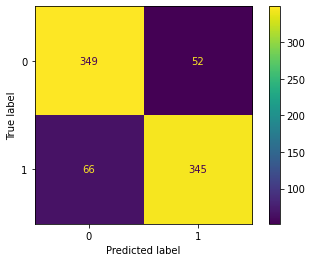

In [ ]:
#Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(binary_test_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                              display_labels= naiveBayes_pipeline.classes_)
disp.plot()


plt.show()

#### Multi

In [ ]:
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score

In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for multiclass classification.

grid_parameters =  {
    'TfidfVectorizer__ngram_range' : [(1,1) , (1,2), (1,3)],
    'TfidfVectorizer__min_df' : [100, 500, 1000],
    'TfidfVectorizer__norm' : ['l1' , 'l2']

}

clf = GridSearchCV(naiveBayes_pipeline, grid_parameters,verbose=1, scoring='f1_macro')
clf.fit(multiclass_train_x, multiclass_train_y)



Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 2min 7s, sys: 2.82 s, total: 2min 10s
Wall time: 2min 11s


In [ ]:
# Report the standart deviation of split scores for each hyperparameter group.

grid_scores = pd.DataFrame(clf.cv_results_)
grid_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_TfidfVectorizer__min_df,param_TfidfVectorizer__ngram_range,param_TfidfVectorizer__norm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.458296,0.011358,0.134720,0.005017,100,"(1, 1)",l1,"{'TfidfVectorizer__min_df': 100, 'TfidfVectori...",0.417301,0.431554,0.429753,0.435580,0.420396,0.426917,0.006922,6
1,0.447850,0.006711,0.132899,0.005058,100,"(1, 1)",l2,"{'TfidfVectorizer__min_df': 100, 'TfidfVectori...",0.436418,0.452912,0.456288,0.460838,0.434259,0.448143,0.010775,3
2,1.206519,0.018048,0.216033,0.006655,100,"(1, 2)",l1,"{'TfidfVectorizer__min_df': 100, 'TfidfVectori...",0.419563,0.444462,0.444753,0.442315,0.424894,0.435197,0.010756,4
3,1.201664,0.014003,0.220490,0.008172,100,"(1, 2)",l2,"{'TfidfVectorizer__min_df': 100, 'TfidfVectori...",0.444514,0.462457,0.473281,0.464048,0.446227,0.458105,0.011048,1
4,2.159760,0.024710,0.298527,0.007269,100,"(1, 3)",l1,"{'TfidfVectorizer__min_df': 100, 'TfidfVectori...",0.419563,0.444462,0.444753,0.442315,0.424894,0.435197,0.010756,4
5,2.130520,0.029523,0.302568,0.013400,100,"(1, 3)",l2,"{'TfidfVectorizer__min_df': 100, 'TfidfVectori...",0.444514,0.462457,0.473281,0.464048,0.446227,0.458105,0.011048,1
6,0.363366,0.007699,0.083047,0.004635,500,"(1, 1)",l1,"{'TfidfVectorizer__min_df': 500, 'TfidfVectori...",0.377962,0.391137,0.389008,0.374723,0.365068,0.379580,0.009584,10
7,0.365935,0.009824,0.080544,0.001591,500,"(1, 1)",l2,"{'TfidfVectorizer__min_df': 500, 'TfidfVectori...",0.387935,0.417106,0.422662,0.393659,0.374267,0.399126,0.018167,7
8,1.099606,0.005497,0.162758,0.006590,500,"(1, 2)",l1,"{'TfidfVectorizer__min_df': 500, 'TfidfVectori...",0.377962,0.391137,0.389008,0.374723,0.365068,0.379580,0.009584,10
9,1.108991,0.021625,0.161504,0.002469,500,"(1, 2)",l2,"{'TfidfVectorizer__min_df': 500, 'TfidfVectori...",0.387935,0.417106,0.422662,0.393659,0.374267,0.399126,0.018167,7


In [ ]:
# Show the best parameter set for given dataset and hyperparameter space.

print("Best Score: ", clf.best_score_)
print("Best Hyperparameters: ", clf.best_params_)

Best Score:  0.45810533402035347
Best Hyperparameters:  {'TfidfVectorizer__min_df': 100, 'TfidfVectorizer__ngram_range': (1, 2), 'TfidfVectorizer__norm': 'l2'}


In [ ]:
# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
# Create your pipeline object with the best parameter set.

naiveBayes_components = [('TfidfVectorizer' , TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 100)), ('DenseTransformer' , DenseTransformer()), ('NBClassifier' , GaussianNB())]
naiveBayes_pipeline = Pipeline(naiveBayes_components)


# Fit your pipeline on training set.
naiveBayes_pipeline.fit(multiclass_train_x, multiclass_train_y)

# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.
multiclass_pred_y= naiveBayes_pipeline.predict(multiclass_test_x)

f1_score = f1_score(multiclass_test_y,multiclass_pred_y, average ="macro")
acc_score = accuracy_score(multiclass_test_y, multiclass_pred_y)
print("F1 Score: ", f1_score)
print("Accuracy Score: ", acc_score)


F1 Score:  0.46108191335759807
Accuracy Score:  0.475


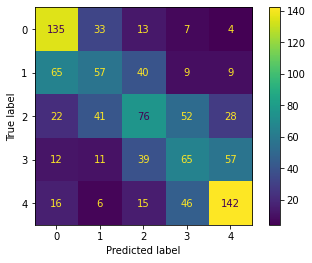

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(multiclass_test_y, multiclass_pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                              display_labels= naiveBayes_pipeline.classes_)
disp.plot()


plt.show()

### Logistic Regression

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Initiate the pipeline with required components.You can use Pipeline class of sklearn -> https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# There will be three components; 1) Word weightning 2) Logistic Regression classifier.

logistic_regression_components = [('WordWeightning' ,TfidfVectorizer(analyzer = 'word')), ('LogRegClassifier', LogisticRegression(random_state = 22))]
logistic_regression_pipeline = Pipeline(logistic_regression_components)



#Set the hyperparameter space that will be scanned.
logreg_grid_parameters =  {
    'WordWeightning__ngram_range' : [(1,1) , (1,2), (1,3)],
    'WordWeightning__min_df' : [100, 500, 1000],
    'LogRegClassifier__penalty' : ['l1' , 'l2'],
    'LogRegClassifier__l1_ratio' : [0.0, 0.5, 1.0]

}



#### Binary

In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for binary classification.

clf = GridSearchCV(logistic_regression_pipeline, logreg_grid_parameters,verbose = 4, scoring='f1_macro')
clf.fit(binary_train_x, binary_train_y)



Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END LogRegClassifier__l1_ratio=0.0, LogRegClassifier__penalty=l1, WordWeightning__min_df=100, WordWeightning__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 2/5] END LogRegClassifier__l1_ratio=0.0, LogRegClassifier__penalty=l1, WordWeightning__min_df=100, WordWeightning__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 3/5] END LogRegClassifier__l1_ratio=0.0, LogRegClassifier__penalty=l1, WordWeightning__min_df=100, WordWeightning__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 4/5] END LogRegClassifier__l1_ratio=0.0, LogRegClassifier__penalty=l1, WordWeightning__min_df=100, WordWeightning__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 5/5] END LogRegClassifier__l1_ratio=0.0, LogRegClassifier__penalty=l1, WordWeightning__min_df=100, WordWeightning__ngram_range=(1, 1);, score=nan total time=   0.3s
[CV 1/5] END LogRegClassifier__l1_ratio=0.0, LogRegClassifier__penalty=l1, WordWeightning__mi

In [ ]:
# Report the standart deviation of split scores for each hyperparameter group.

grid_scores = pd.DataFrame(clf.cv_results_)
grid_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LogRegClassifier__l1_ratio,param_LogRegClassifier__penalty,param_WordWeightning__min_df,param_WordWeightning__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.295154,0.015819,0.000000,0.000000,0.0,l1,100,"(1, 1)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,37
1,0.856714,0.017048,0.000000,0.000000,0.0,l1,100,"(1, 2)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,39
2,1.540328,0.019434,0.000000,0.000000,0.0,l1,100,"(1, 3)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
3,0.285468,0.005667,0.000000,0.000000,0.0,l1,500,"(1, 1)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,41
4,0.863756,0.009106,0.000000,0.000000,0.0,l1,500,"(1, 2)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,42
5,1.754073,0.410205,0.000000,0.000000,0.0,l1,500,"(1, 3)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
6,0.660408,0.166928,0.000000,0.000000,0.0,l1,1000,"(1, 1)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,44
7,0.847721,0.009423,0.000000,0.000000,0.0,l1,1000,"(1, 2)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,46
8,1.533331,0.013892,0.000000,0.000000,0.0,l1,1000,"(1, 3)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,53
9,0.350106,0.006987,0.062431,0.002206,0.0,l2,100,"(1, 1)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",0.889013,0.880557,0.886854,0.876346,0.883265,0.883207,0.004497,7


In [ ]:
# Show the best parameter set for given dataset and hyperparameter space.

print("Best Score: ", clf.best_score_)
print("Best Hyperparameters: ", clf.best_params_)

Best Score:  0.8847436551308672
Best Hyperparameters:  {'LogRegClassifier__l1_ratio': 0.0, 'LogRegClassifier__penalty': 'l2', 'WordWeightning__min_df': 100, 'WordWeightning__ngram_range': (1, 2)}


In [ ]:
from sklearn.metrics import f1_score
# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
# Create your Pipeline object with the best parameter set.

logistic_regression_components = [('WordWeightning' ,TfidfVectorizer(analyzer = 'word' , min_df = 100, ngram_range=(1,2))), ('LogRegClassifier', LogisticRegression(random_state = 22 , penalty = "l2"))]
logistic_regression_pipeline = Pipeline(logistic_regression_components)



# Fit your pipeline on training set.

logistic_regression_pipeline.fit(binary_train_x, binary_train_y)

# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.
pred_y= logistic_regression_pipeline.predict(binary_test_x)

f1_score = f1_score(binary_test_y,pred_y)
acc_score = accuracy_score(binary_test_y, pred_y)
print("F1 Score: ", f1_score)
print("Accuracy Score: ", acc_score)

F1 Score:  0.8899876390605687
Accuracy Score:  0.8903940886699507


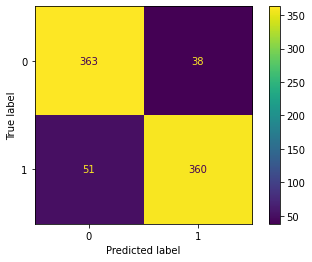

In [ ]:
#Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(binary_test_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                              display_labels= logistic_regression_pipeline.classes_)
disp.plot()


plt.show()

#### Multiclass

In [ ]:
multi_logistic_regression_components = [('WordWeightning' ,TfidfVectorizer(analyzer = 'word')), ('LogRegClassifier', LogisticRegression(random_state = 22))]
multi_logistic_regression_pipeline = Pipeline(multi_logistic_regression_components)



#Set the hyperparameter space that will be scanned.
multi_logreg_grid_parameters =  {
    'WordWeightning__ngram_range' : [(1,1) , (1,2), (1,3)],
    'WordWeightning__min_df' : [100, 500, 1000],
    'LogRegClassifier__penalty' : ['l1' , 'l2'],
    'LogRegClassifier__l1_ratio' : [0.0, 0.5, 1.0],
    'LogRegClassifier__multi_class' : ['auto', 'multinomial']

}

In [ ]:
%%time
# Initialize and run the GridSearchCV to scan the hyperparameter and find the best hyperparameter set that will maximize the scoring option for multiclass classification.
clf = GridSearchCV(multi_logistic_regression_pipeline, multi_logreg_grid_parameters,verbose = 0, scoring='f1_macro')
clf.fit(multiclass_train_x, multiclass_train_y)


CPU times: user 13min 59s, sys: 14 s, total: 14min 13s
Wall time: 14min 16s


In [ ]:
# Report the standart deviation of split scores for each hyperparameter group.

grid_scores = pd.DataFrame(clf.cv_results_)
grid_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LogRegClassifier__l1_ratio,param_LogRegClassifier__multi_class,param_LogRegClassifier__penalty,param_WordWeightning__min_df,param_WordWeightning__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.361344,0.010056,0.000000,0.000000,0.0,auto,l1,100,"(1, 1)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,108
1,1.270264,0.196816,0.000000,0.000000,0.0,auto,l1,100,"(1, 2)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,77
2,2.260632,0.245077,0.000000,0.000000,0.0,auto,l1,100,"(1, 3)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
3,0.353533,0.004049,0.000000,0.000000,0.0,auto,l1,500,"(1, 1)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,75
4,1.137413,0.012087,0.000000,0.000000,0.0,auto,l1,500,"(1, 2)","{'LogRegClassifier__l1_ratio': 0.0, 'LogRegCla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1.677034,0.012815,0.164437,0.006322,1.0,multinomial,l2,500,"(1, 2)","{'LogRegClassifier__l1_ratio': 1.0, 'LogRegCla...",0.443675,0.456564,0.448961,0.423519,0.429889,0.440521,0.012171,19
104,2.547796,0.015826,0.247220,0.007283,1.0,multinomial,l2,500,"(1, 3)","{'LogRegClassifier__l1_ratio': 1.0, 'LogRegCla...",0.443675,0.456564,0.448961,0.423519,0.429889,0.440521,0.012171,19
105,0.558335,0.017819,0.071403,0.002026,1.0,multinomial,l2,1000,"(1, 1)","{'LogRegClassifier__l1_ratio': 1.0, 'LogRegCla...",0.346295,0.333591,0.332611,0.328795,0.336503,0.335559,0.005907,37
106,1.328657,0.029059,0.153369,0.006237,1.0,multinomial,l2,1000,"(1, 2)","{'LogRegClassifier__l1_ratio': 1.0, 'LogRegCla...",0.346295,0.333591,0.332611,0.328795,0.336503,0.335559,0.005907,37


In [ ]:
# Show the best parameter set for given dataset and hyperparameter space.

print("Best Score: ", clf.best_score_)
print("Best Hyperparameters: ", clf.best_params_)

Best Score:  0.5108437884395868
Best Hyperparameters:  {'LogRegClassifier__l1_ratio': 0.0, 'LogRegClassifier__multi_class': 'auto', 'LogRegClassifier__penalty': 'l2', 'WordWeightning__min_df': 100, 'WordWeightning__ngram_range': (1, 2)}


In [ ]:
from sklearn.metrics import f1_score
# Building the pipeline with the best parameter group and reporting Conf. Mat. and Results on the Test Set #
# Create your Pipeline object with the best parameter set.

multi_logistic_regression_components = [('WordWeightning' ,TfidfVectorizer(analyzer = 'word' , min_df = 100, ngram_range=(1,2))), ('LogRegClassifier', LogisticRegression(random_state = 22 , penalty = "l2", multi_class='multinomial'))]
multi_logistic_regression_pipeline = Pipeline(multi_logistic_regression_components)



# Fit your pipeline on training set.

multi_logistic_regression_pipeline.fit(multiclass_train_x, multiclass_train_y)

# Take prediction and report the F1 and Accuracy scores for binary classification. Then show the confussion table.
multiclass_pred_y= multi_logistic_regression_pipeline.predict(multiclass_test_x,)

f1_score = f1_score(multiclass_test_y,multiclass_pred_y, average ="macro")
acc_score = accuracy_score(multiclass_test_y, multiclass_pred_y)
print("F1 Score: ", f1_score)
print("Accuracy Score: ", acc_score)

F1 Score:  0.5195094567239478
Accuracy Score:  0.523


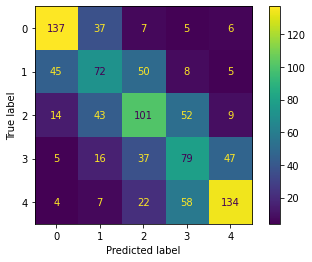

In [ ]:
#Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cf_matrix = confusion_matrix(multiclass_test_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                              display_labels= multi_logistic_regression_pipeline.classes_)
disp.plot()


plt.show()

## Neural Models

### Convolutional Neural Network (CNN)

-----Used Resources-----

https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/
https://machinelearningmastery.com/best-practices-document-classification-deep-learning/

In [ ]:
import pandas as pd
import numpy as np
import nltk,re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy import array,asarray,zeros

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers import Dense,Flatten,Embedding,Input,Dropout
from keras.callbacks import ModelCheckpoint

from gensim.models import Word2Vec
import gensim.downloader as api

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Create a validation set from train set
# Please use random_state of 22 and test_size of 0.1

binary_validation = binary_train.sample(frac=0.1, random_state = 22)
binary_train = binary_train.drop(binary_validation.index)

multiclass_validation = multiclass_train.sample(frac=0.1, random_state = 22)
multiclass_train= multiclass_train.drop(multiclass_validation.index)


In [ ]:
binary_train_corpus = list(binary_train['text'].str.split(' '))
multi_train_corpus = list(multiclass_train['text'].str.split(' '))

In [ ]:
# Create your own word embeddings from scratch and load a pretrained word embeddings





# You can check https://radimrehurek.com/gensim/models/word2vec.html for training a word embeddings from scratch

binary_w2v_model = Word2Vec(sentences=binary_train_corpus, size = 100, window=5, min_count=1, workers=4)
multi_w2v_model = Word2Vec(sentences=multi_train_corpus, size = 100, window=5, min_count=1, workers=4)

filename_binary ="binary_w2v_model.txt"
filename_multi = "multi_w2v_model.txt"

binary_w2v_model.wv.save_word2vec_format(filename_binary, binary=False)
multi_w2v_model.wv.save_word2vec_format(filename_multi, binary=False)



# You can check https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html and https://github.com/RaRe-Technologies/gensim-data for loading pretrained word embeddings. 

pretrained_embedding = api.load("glove-twitter-100")




In [ ]:
#save pretrained embedding
filename_pretrained = "pretrained_embedding.txt"
binary_w2v_model.wv.save_word2vec_format(filename_pretrained, binary=False)

In [ ]:
# Prepare your dataset for CNN classifier
total_binary_reviews = list(binary_train['text'].values)  #+ list(binary_test['text'].values) + list(binary_validation['text'].values)
total_multiclass_reviews = list(multiclass_train['text']) #+ list(multiclass_test['text']) + list(multiclass_validation['text'])

binary_tokenizer = Tokenizer(oov_token='OOV')
binary_tokenizer.fit_on_texts(total_binary_reviews)

multi_tokenizer = Tokenizer(oov_token='OOV')
multi_tokenizer.fit_on_texts(multiclass_train.text)


binary_max_length = max([len(s.split()) for s in total_binary_reviews])
multi_max_length = max([len(s.split()) for s in total_multiclass_reviews])



In [ ]:
print("Max length text in binary dataset: ", binary_max_length)
print("Max length text in multiclass dataset: ", multi_max_length)

Max length text in binary dataset:  496
Max length text in multiclass dataset:  495


In [ ]:
binary_vocab_size = len(binary_tokenizer.word_index)+1
print(binary_vocab_size)

23072


In [ ]:
multi_vocab_size = len(multi_tokenizer.word_index)+1
print(multi_vocab_size)

26550


In [ ]:
#tokenize the dataset
x_binary_train = binary_train['text'].values.tolist()
x_binary_train_tokens = binary_tokenizer.texts_to_sequences(x_binary_train)
y_binary_train = binary_train['label']

x_binary_validation = binary_validation['text'].values.tolist()
x_binary_validation_tokens = binary_tokenizer.texts_to_sequences(x_binary_validation)
y_binary_validation = binary_validation['label']

x_binary_test = list(binary_test['text'].values)
y_binary_test = binary_test['label']
x_binary_test_tokens = binary_tokenizer.texts_to_sequences(x_binary_test)

x_multi_train = multiclass_train['text'].values.tolist()
x_multi_train_tokens = multi_tokenizer.texts_to_sequences(x_multi_train)
y_multi_train = multiclass_train['label']

x_multi_validation = multiclass_validation['text'].values.tolist()
x_multi_validation_tokens = multi_tokenizer.texts_to_sequences(x_multi_validation)
y_multi_validation = multiclass_validation['label']

x_multi_test = multiclass_test['text'].values.tolist()
x_multi_test_tokens = multi_tokenizer.texts_to_sequences(x_multi_test)
y_multi_test = multiclass_test['label']

#padding
x_binary_train_pad = pad_sequences(x_binary_train_tokens, maxlen = binary_max_length, padding = 'post')
x_binary_test_pad = pad_sequences(x_binary_test_tokens, maxlen = binary_max_length, padding = 'post')
x_binary_validation_pad = pad_sequences(x_binary_validation_tokens, maxlen = binary_max_length, padding = 'post')

x_multi_train_pad = pad_sequences(x_multi_train_tokens, maxlen = multi_max_length, padding = 'post')
x_multi_validation_pad = pad_sequences(x_multi_validation_tokens, maxlen = multi_max_length, padding = 'post')
x_multi_test_pad = pad_sequences(x_multi_test_tokens, maxlen = multi_max_length, padding = 'post')

In [ ]:
#creating embedding matrix
import os
EMBEDDING_DIM = 100

def create_embedding_matrix(filename, tokenizer):
  word_index = tokenizer.word_index
  num_words = len(word_index)+1
  embeddings_index={}
  f=open(os.path.join('',filename),encoding='utf-8')

  for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
  f.close()
  embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))
  for word, i in word_index.items():
    if i>num_words:
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i]=embedding_vector
  return embedding_matrix

#binary
binary_w2v_embedding_matrix = create_embedding_matrix(filename_binary, binary_tokenizer)
multi_w2c_embedding_matrix = create_embedding_matrix(filename_multi, multi_tokenizer)

pretrained_embedding_matrix_binary = create_embedding_matrix(filename_pretrained,binary_tokenizer)
pretrained_embedding_matrix_multi = create_embedding_matrix(filename_pretrained,multi_tokenizer)

####Neural Models for Binary Classification

#####Randomly Initialized Word Embeddings

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

EMBEDDING_DIM = 100
filters = [32,64]
kernels = [8,16]
hidden_layers_size = [10,32]
for f in filters:
  for k in kernels:
    for h in hidden_layers_size:
      model_random_binary_1 = Sequential()
      model_random_binary_1.add(Embedding(binary_vocab_size, EMBEDDING_DIM, input_length = binary_max_length))
      model_random_binary_1.add(Conv1D(filters=f, kernel_size=k, activation='relu'))
      model_random_binary_1.add(MaxPooling1D(pool_size=2))
      model_random_binary_1.add(Flatten())
      model_random_binary_1.add(Dense(h, activation='relu'))
      model_random_binary_1.add(Dense(1, activation='sigmoid')) #using sigmoid because of binary classficiation

      # compile network
      model_random_binary_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      # fit network
      model_random_binary_1.fit(x_binary_train_pad, y_binary_train, epochs=8, verbose=0, validation_data=(x_binary_validation_pad, y_binary_validation))

      loss, acc = model_random_binary_1.evaluate(x_binary_test_pad, y_binary_test)
      print("************ FILTER SIZE: " ,f, "KERNEL: ", k , "HIDDEN LAYER: ", h ,'TEST ACCURACY: %f' % (acc*100) , "************")
      print("************ CLASSIFICATION REPORT ************")
      y_pred = model_random_binary_1.predict(x_binary_test_pad)
      predicted_classes = y_pred.astype(int).tolist()
      print(classification_report(y_binary_test, predicted_classes))
      print("*********************************")



26/26 [==============================] - 1s 23ms/step - loss: 0.6014 - accuracy: 0.8953
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  10 TEST ACCURACY: 89.532018 ************
************ CLASSIFICATION REPORT ************
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       401
           1       0.99      0.20      0.33       411

    accuracy                           0.59       812
   macro avg       0.77      0.60      0.52       812
weighted avg       0.77      0.59      0.52       812

*********************************
26/26 [==============================] - 1s 23ms/step - loss: 0.5622 - accuracy: 0.8941
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  32 TEST ACCURACY: 89.408869 ************
************ CLASSIFICATION REPORT ************
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       401
           1       1.00      0.01      0.03       411

    accur

#####Word2Vec Embedding

In [ ]:
#Creating embedding matrices and layers

w2v_binary_embedding_layer = Embedding(len(binary_tokenizer.word_index)+1,  EMBEDDING_DIM ,weights = [binary_w2v_embedding_matrix],input_length = binary_max_length)

EMBEDDING_DIM = 100
filters = [32,64]
kernels = [8,16]
hidden_layers_size = [10,32]
for f in filters:
  for k in kernels:
    for h in hidden_layers_size:

      model = Sequential()
      model.add(w2v_binary_embedding_layer)
      model.add(Conv1D(filters=f, kernel_size=k, activation='relu'))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Flatten())
      model.add(Dense(h, activation='relu'))
      model.add(Dense(1, activation='sigmoid')) #using sigmoid because of binary classficiation
      # compile network
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      # fit network
      model.fit(x_binary_train_pad, y_binary_train, epochs=8,verbose= 0, validation_data=(x_binary_validation_pad, y_binary_validation))
      loss, acc = model.evaluate(x_binary_test_pad, y_binary_test)
      print("************ FILTER SIZE: " ,f, "KERNEL: ", k , "HIDDEN LAYER: ", h ,'TEST ACCURACY: %f' % (acc*100) , "************")
      print("************ CLASSIFICATION REPORT ************")
      y_pred = model.predict(x_binary_test_pad)
      predicted_classes = y_pred.astype(int).tolist()
      print(classification_report(y_binary_test, predicted_classes))
      print("*********************************")

26/26 [==============================] - 1s 22ms/step - loss: 0.5521 - accuracy: 0.8916
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  10 TEST ACCURACY: 89.162564 ************
************ CLASSIFICATION REPORT ************
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       401
           1       0.99      0.25      0.40       411

    accuracy                           0.62       812
   macro avg       0.78      0.62      0.56       812
weighted avg       0.78      0.62      0.56       812

*********************************
26/26 [==============================] - 1s 21ms/step - loss: 0.7648 - accuracy: 0.8916
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  32 TEST ACCURACY: 89.162564 ************
************ CLASSIFICATION REPORT ************
              precision    recall  f1-score   support

           0       0.64      0.99      0.78       401
           1       0.97      0.47      0.63       411

    accur

#####Pretrained Embedding

In [ ]:
#create embedding layer
pretrained_binary_embedding_layer = Embedding(len(binary_tokenizer.word_index)+1,  EMBEDDING_DIM ,weights = [pretrained_embedding_matrix_binary],input_length = binary_max_length)
pretrained_binary_acc = []
pretrained_binary_f1 = []
filters = [32,64]
kernels = [8,16]
hidden_layers_size = [10,32]

for f in filters:
  for k in kernels:
    for h in hidden_layers_size:
      model = Sequential()
      model.add(pretrained_binary_embedding_layer)
      model.add(Conv1D(filters=f, kernel_size=k, activation='relu'))
      model.add(MaxPooling1D(pool_size=2))
      model.add(Flatten())
      model.add(Dense(h, activation='relu'))
      model.add(Dense(1, activation='sigmoid')) #using sigmoid because of binary classficiation

      # compile network
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
      # fit network
      model.fit(x_binary_train_pad, y_binary_train, epochs=8,verbose= 0,  validation_data=(x_binary_validation_pad, y_binary_validation))

      loss, acc = model.evaluate(x_binary_test_pad, y_binary_test)
      print("************ FILTER SIZE: " ,f, "KERNEL: ", k , "HIDDEN LAYER: ", h ,'TEST ACCURACY: %f' % (acc*100) , "************")
      print("************ CLASSIFICATION REPORT ************")
      y_pred = model.predict(x_binary_test_pad)
      predicted_classes = y_pred.astype(int).tolist()
      print(classification_report(y_binary_test, predicted_classes))
      print("*********************************")

26/26 [==============================] - 1s 23ms/step - loss: 0.5756 - accuracy: 0.8990
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  10 TEST ACCURACY: 89.901477 ************
************ CLASSIFICATION REPORT ************
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       401
           1       0.99      0.28      0.44       411

    accuracy                           0.63       812
   macro avg       0.78      0.64      0.58       812
weighted avg       0.79      0.63      0.58       812

*********************************
26/26 [==============================] - 1s 23ms/step - loss: 0.7505 - accuracy: 0.8830
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  32 TEST ACCURACY: 88.300490 ************
************ CLASSIFICATION REPORT ************
              precision    recall  f1-score   support

           0       0.63      0.99      0.77       401
           1       0.98      0.43      0.60       411

    accur

####Neural Models for Multiclass Classification


#####Randomly Initialized Word Embeddings

In [ ]:
# Create Embedding Matrices and Layers
EMBEDDING_DIM = 100

filters = [32,64]
kernels = [8,16]
hidden_layers_size = [10,32]

for f in filters:
  for k in kernels:
    for h in hidden_layers_size:
      model_random_multi = Sequential()
      model_random_multi.add(Embedding(multi_vocab_size, EMBEDDING_DIM, input_length = multi_max_length))
      model_random_multi.add(Conv1D(filters=f, kernel_size=k, activation='relu'))
      model_random_multi.add(MaxPooling1D(pool_size=2))
      model_random_multi.add(Flatten())
      model_random_multi.add(Dense(h, activation='relu'))
      model_random_multi.add(Dense(5, activation='softmax'))
      # compile network
      model_random_multi.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      # fit network
      model_random_multi.fit(x_multi_train_pad, y_multi_train, epochs=8, verbose=0, validation_data=(x_multi_validation_pad, y_multi_validation))
      loss, acc = model_random_multi.evaluate(x_multi_test_pad, y_multi_test)
      print("************ FILTER SIZE: " ,f, "KERNEL: ", k , "HIDDEN LAYER: ", h ,'TEST ACCURACY: %f' % (acc*100) , "************")
      print("************ CLASSIFICATION REPORT ************")
      y_pred = model_random_multi.predict(x_multi_test_pad)
      predicted_classes =  np.argmax(y_pred, axis=1)
      print(classification_report(y_multi_test, predicted_classes))
      print("*********************************")

32/32 [==============================] - 1s 22ms/step - loss: 3.4149 - accuracy: 0.4460
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  10 TEST ACCURACY: 44.600001 ************
************ CLASSIFICATION REPORT ************
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       192
           1       0.39      0.43      0.41       180
           2       0.35      0.42      0.38       219
           3       0.32      0.35      0.34       184
           4       0.64      0.49      0.55       225

    accuracy                           0.45      1000
   macro avg       0.46      0.44      0.45      1000
weighted avg       0.47      0.45      0.45      1000

*********************************
32/32 [==============================] - 1s 23ms/step - loss: 4.0644 - accuracy: 0.4570
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  32 TEST ACCURACY: 45.699999 ************
************ CLASSIFICATION REPORT ************
           

#####Word2Vec Embedding

In [ ]:
w2v_multi_embedding_layer = Embedding(len(multi_tokenizer.word_index)+1,  EMBEDDING_DIM ,weights = [multi_w2c_embedding_matrix],input_length = multi_max_length)

filters = [32,64]
kernels = [8,16]
hidden_layers_size = [10,32]

for f in filters:
  for k in kernels:
    for h in hidden_layers_size:

      model_w2v_multi = Sequential()
      model_w2v_multi.add(w2v_multi_embedding_layer)
      model_w2v_multi.add(Conv1D(filters=f, kernel_size=k, activation='relu'))
      model_w2v_multi.add(MaxPooling1D(pool_size=2))
      model_w2v_multi.add(Flatten())
      model_w2v_multi.add(Dense(h, activation='relu'))
      model_w2v_multi.add(Dense(5, activation='softmax'))

      # compile network
      model_w2v_multi.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      # fit network
      model_w2v_multi.fit(x_multi_train_pad, y_multi_train, epochs=8, verbose=0, validation_data=(x_multi_validation_pad, y_multi_validation))

      loss, acc = model_w2v_multi.evaluate(x_multi_test_pad, y_multi_test)
      print("************ FILTER SIZE: " ,f, "KERNEL: ", k , "HIDDEN LAYER: ", h ,'TEST ACCURACY: %f' % (acc*100) , "************")
      print("************ CLASSIFICATION REPORT ************")
      y_pred = model_w2v_multi.predict(x_multi_test_pad)
      predicted_classes =  np.argmax(y_pred, axis=1)
      print(classification_report(y_multi_test, predicted_classes))
      print("*********************************")

32/32 [==============================] - 1s 24ms/step - loss: 2.4421 - accuracy: 0.4860
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  10 TEST ACCURACY: 48.600000 ************
************ CLASSIFICATION REPORT ************
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       192
           1       0.38      0.44      0.41       180
           2       0.38      0.39      0.38       219
           3       0.40      0.50      0.44       184
           4       0.75      0.49      0.59       225

    accuracy                           0.49      1000
   macro avg       0.51      0.49      0.49      1000
weighted avg       0.52      0.49      0.49      1000

*********************************
32/32 [==============================] - 1s 25ms/step - loss: 4.8432 - accuracy: 0.4770
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  32 TEST ACCURACY: 47.700000 ************
************ CLASSIFICATION REPORT ************
           

#####Pretrained Embeddings

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

#create embedding layer
pretrained_multi_embedding_layer = Embedding(len(multi_tokenizer.word_index)+1,  EMBEDDING_DIM ,weights = [pretrained_embedding_matrix_multi],input_length = multi_max_length)

filters = [32,64]
kernels = [8,16]
hidden_layers_size = [10,32]

for f in filters:
  for k in kernels:
    for h in hidden_layers_size:
      model_pretrained_multi = Sequential()
      model_pretrained_multi.add(pretrained_multi_embedding_layer)
      model_pretrained_multi.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
      model_pretrained_multi.add(MaxPooling1D(pool_size=2))
      model_pretrained_multi.add(Flatten())
      model_pretrained_multi.add(Dense(32, activation='relu'))
      model_pretrained_multi.add(Dense(5, activation='softmax'))

      # compile network
      model_pretrained_multi.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      # fit network
      model_pretrained_multi.fit(x_multi_train_pad, y_multi_train, epochs=8, verbose=0, validation_data=(x_multi_validation_pad, y_multi_validation))
      
      loss, acc = model_pretrained_multi.evaluate(x_multi_test_pad, y_multi_test)
      print("************ FILTER SIZE: " ,f, "KERNEL: ", k , "HIDDEN LAYER: ", h ,'TEST ACCURACY: %f' % (acc*100) , "************")
      print("************ CLASSIFICATION REPORT ************")
      y_pred = model_pretrained_multi.predict(x_multi_test_pad)
      predicted_classes =  np.argmax(y_pred, axis=1)
      print(classification_report(y_multi_test, predicted_classes))
      print("*********************************")

      #confusion matrix
      #cf_matrix = confusion_matrix(y_multi_test, y_pred_class)
      #disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
      #disp.plot()
      #plt.show()

32/32 [==============================] - 1s 23ms/step - loss: 2.8835 - accuracy: 0.4560
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  10 TEST ACCURACY: 45.600000 ************
************ CLASSIFICATION REPORT ************
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       192
           1       0.36      0.39      0.37       180
           2       0.35      0.33      0.34       219
           3       0.32      0.36      0.34       184
           4       0.66      0.57      0.61       225

    accuracy                           0.46      1000
   macro avg       0.46      0.45      0.46      1000
weighted avg       0.47      0.46      0.46      1000

*********************************
32/32 [==============================] - 1s 23ms/step - loss: 4.4469 - accuracy: 0.4720
************ FILTER SIZE:  32 KERNEL:  8 HIDDEN LAYER:  32 TEST ACCURACY: 47.200000 ************
************ CLASSIFICATION REPORT ************
           

## My Report
###Data
After reaing the train and test data, I have checked the first 3 instances of the train dataset. I have seen that there are 3 fields; Unnamed, text and label. I have checked if any of instances of the train data contains NaN values in these fields. There doese not exist any NaN values so it won't need any handling.
###Preprocessing
In the preprocessing, I lowercased all the letters, removed html tags, URLs, stopwords, extra unnecesary whitespaces to reduce the number of features. I have chosed not to use Porter Stemmer because as we have seen in the lecture, it stems the words too much and it has low performance.
###Naive Bayes
In Naive Bayes, I have created the pipeline with TfIdfVectorizer,  DenseTramsformer and Gaussian NB.
For binary classification, I found the best result by using min_df = 100 and ngram_range = (1,2) for TfIdfVectorizer with F1 Score:  0.853960396039604 and
Accuracy Score:  0.854679802955665. Min_df=100 was expected because our corpus isn't very large and since these are reviews from users, there should exist unique slang words as well. 

For multiclass classification, I have tried the model with different norms as well as ngram ranges and min_df. Best result came with l2 norm, ngram_range = (1,2) and min_df=100 with F1 Score:  0.46108191335759807
Accuracy Score:  0.475. 

Interesting outcome is that trigrams did not perform well on the model and I have created the pipeline using n_gram range as (1,2) for both of the classifications.
Overall, Naive Bayes did not perform well due to its conditional independence assumption for the features

Accuracy and f1 score reduces drastically for multiclass classification and Naive Bayes is not a good fit for the multiclass classification problem.
###Logistic Regression
In Logistic Regression, I have created the pipeline with TdIdfVectorizer and Logistic Regression Classifier.

For binary classification, I found the best result by using min_df = 100, n_gram_range = (1,2) and l1_penalty = 0 => meaning penalty= l2 with F1 Score:  0.8899876390605687
Accuracy Score:  0.8903940886699507 which is a better performance than binary classification with naive bayes.

For multiclass classification, I have found the best result by using min_df =100, n_gram range = (1,2) for TfIdfVectorizer and penalty = l2 for Logistic Regression Classifier. Got the scores as F1 Score:  0.5195094567239478
Accuracy Score:  0.523 which is again a better performance than Naive Bayes.
###CNN
First, I had to prepare the data for CNN. For that purpose i applied tokenization and padding so that each word will have the same length.

From the lectures, we know that simple models work better for NLP classification tasks. So, i used 1 convolution layer, max pooling and then 2 dense layers. I have tried kernel sizes as 8 and 16, amount of filters as 16 and 32 and hidden layer size as 10 and 32. 
For the last dense layer, sizes vary as 1 and 5. 1 for binary classification and 5 for multiclass.

I have used word embedding dimensions as 100

For binary classification:

Randomly Initialized Embeddings performed better with 32 filters, kernel size as 16 and hidden layer size as 32 with test accuracy: 89.901477

Word2Vec Embeddings performed better with 32 filters kernel size as 16 and hidden layer size as 32 with test accuracy: 89.162564 and highest f1 scores. 

Pretrained Embeddings performed better with 32 filters kernel size as 8 and hidden layer size as  10 with highest test accuracy: 89.901477.

Overall, it is seen that small filter size performs well for these models.

For multiclass:

Randomly Initialized Embeddings performed better with 32 filters, kernel size as 16 and hidden layer size as 10 with test accuracy: 48.899999


Word2Vec Embeddings performed better with 32 filters, kernel size as 8  and hidden layer size as 10 with test accuracy: 48.600000

Pretrained Embeddings performed better with 32 filters, kernel size as 8 and hidden layer size as 32 with test accuracy: 47.200000

Conclusion:
For binary classification, CNN with randomly initialized embedding and CNN with pretrained embedding (both has accuracy score 89.901477) performed the best. Overall, CNN for binary classification performed better with higher kernel size and higher hidden layer size, 16 and 32 respectively.
However for multiclass classification, CNN with randomly initialized embedding performed the best.
For multiclass, CNN performed better with smaller kernel size and hidden layer size, 8 and 10 respectively.

For both binary and multiclass classification, CNN performed similar to NB and Logistic Regression. This was saddening. CNN outperformed NB and LR in binary classification but fell low on multiclass classification.
